# Analyze Serie A Fantasy League Data

In [6]:
# Imports
import os

from ipywidgets import widgets
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mpldatacursor
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
# Constants
FOLDER_DATA = '../data'
FILENAME_DATA = 'qr2.csv'

%matplotlib notebook
sns.set()

## Load and process data

In [8]:
# Load data
filepath_data = os.path.join(FOLDER_DATA, FILENAME_DATA)
df = pd.read_csv(filepath_data)

In [9]:
# Process data

# Remove players who played less than 10 games last year
N_MIN_GAMES = 10
df = df[df['pg1819'] > N_MIN_GAMES]

# Keep players who played (at least) 2 most recent years
# or had a score equal to 0 last year
cols_mf = ['mf1516', 'mf1617', 'mf1718', 'mf1819']
idxs_to_remove_last_seasons = df[cols_mf[-2:]].isnull().any(axis=1)  # not played last 2 seasons
idxs_to_remove_zeros = df[cols_mf[-1]] == 0  # score is 0 for last season
idxs_to_remove = idxs_to_remove_last_seasons | idxs_to_remove_zeros
df_updated = df[~idxs_to_remove]

# Preview data
df_updated.head()

,id,r1516,nome,squadra1516,pg1516,mv1516,mf1516,gf1516,gs1516,rp1516,...,gs1819,rp1819,rc1819,rplus1819,rminus1819,ass1819,asf1819,amm1819,esp1819,au1819
0,20,C,CIGARINI,Atalanta,24,6.12,6.25,1,0,0,...,0,0,0,0,0,1,0,9,0,0
2,21,C,D'ALESSANDRO,Atalanta,19,6.24,6.74,3,0,0,...,0,0,0,0,0,1,0,3,0,0
3,787,D,DJIMSITI,Atalanta,3,5.33,5.17,0,0,0,...,0,0,0,0,0,1,0,3,0,1
4,788,C,FREULER,Atalanta,6,5.83,6.33,1,0,0,...,0,0,0,0,0,2,0,4,0,0
5,801,C,GAGLIARDINI,Atalanta,1,6.00,6.00,0,0,0,...,0,0,0,0,0,0,0,4,0,0


## Analyze data

### Trends

In [10]:
# Players with constant positive trend

COLS_TRENDS = ['nome', 
               'delta1', 'delta2', 'delta3',
               'mf1516', 'mf1617', 'mf1718', 'mf1819']

data_positive_trend = []
for id_player in df_updated.index:  # for each player...
    player = df_updated.loc[id_player]
    # Calculate score difference between seasons
    curr_mf = player[cols_mf].dropna()
    curr_deltas = [0] * (4 - len(curr_mf))  # delta == 0 for missing years
    
    curr_deltas.extend([curr_mf[i+1] - curr_mf[i] \
                        for i in range(len(curr_mf) - 1)])
    # Check if player has positive differences only...
    n_negative_deltas = sum(np.array(curr_deltas) < 0)
    if n_negative_deltas == 0:
        # ...and add him to the dataset
        row = [player['nome']]
        row.extend(curr_deltas)
        row.extend(player[cols_mf])
        data_positive_trend.append(row)

# Create DataFrame and preview it
df_positive_trend = pd.DataFrame(data=data_positive_trend, 
                                 columns=COLS_TRENDS)
print("Number of players with positive trend:", len(df_positive_trend))
df_positive_trend.head()

Number of players with positive trend: 10


,nome,delta1,delta2,delta3,mf1516,mf1617,mf1718,mf1819
0,BIRAGHI,5.51,0.31,0.18,0.00,5.51,5.82,6.00
1,PANDEV,0.81,0.11,0.18,5.50,6.31,6.42,6.60
2,PAROLO,0.34,0.18,0.03,6.00,6.34,6.52,6.55
3,ROMAGNOLI A,0.12,0.15,0.19,5.82,5.94,6.09,6.28
4,SZCZESNY,0.24,0.10,0.01,5.19,5.43,5.53,5.54


<IPython.core.display.Javascript object>


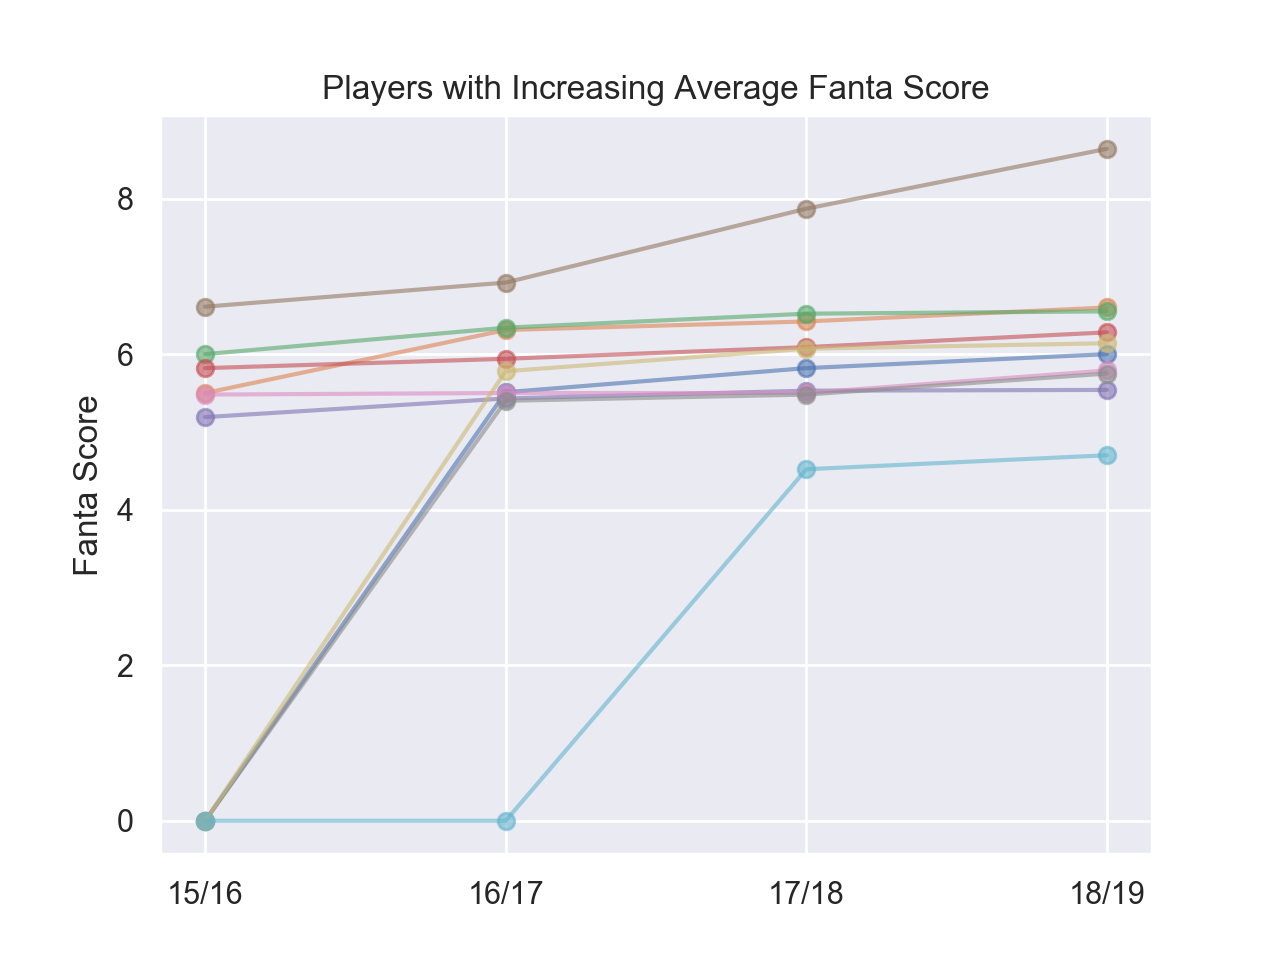

In [11]:
# Plot positive trends

X_TICKS = ['15/16', '16/17', '17/18', '18/19']
# names = ['DZEKO',
#          'BELOTTI',
#          'SALAH',
#          'GOMEZ A',
#          'KEITA B',
#          'BABACAR',
#          'BERNARDESCHI',
#          'BASELLI',
#          'DONNARUMMA G',
#          'SZCZESNY',
#          'MARCHETTI']
names = []

# Get data
if len(names) > 0:
    data = df_positive_trend[df_positive_trend['nome'].isin(names)]
    data = data.sort_values(['mf1617'], ascending=False)
    names = data['nome'].values
    data = data.values[:, 4:]
else:
    data = df_positive_trend.values[:, 4:]

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    if len(names) > 0:
        curr_label = names[i_row]
    else:
        curr_label = df_positive_trend.iloc[i_row, :]['nome']
    ax.plot(row, marker='o', alpha=0.6, label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Increasing Average Fanta Score')
plt.ylabel('Fanta Score')
if len(names) > 0:
    plt.legend()

In [12]:
# Players with constant negative trend

COLS_TRENDS = ['nome', 
               'Delta1', 'Delta2', 'Delta3', 
               'mf1516', 'mf1617', 'mf1718', 'mf1819']

data_negative_trend = []
for id_player in df_updated.index:  # for each player...
    player = df_updated.loc[id_player]
    # Calculate score difference between seasons
    curr_mf = player[cols_mf].dropna()
    curr_deltas = [0] * (4 - len(curr_mf))  # delta == 0 for missing years
    curr_deltas.extend([curr_mf[i+1] - curr_mf[i] \
                        for i in range(len(curr_mf) - 1)])
    # Check if player has negative differences only...
    n_positive_deltas = sum(np.array(curr_deltas) > 0)
    if n_positive_deltas == 0:
        # ...and add him to the dataset
        row = [player['nome']]
        row.extend(curr_deltas)
        row.extend(player[cols_mf])
        data_negative_trend.append(row)
        
# Create DataFrame and preview it
df_negative_trend = pd.DataFrame(data=data_negative_trend, 
                                 columns=COLS_TRENDS)
print("Number of players with negative trend:", len(df_negative_trend))
df_negative_trend.head()

Number of players with negative trend: 7


,nome,Delta1,Delta2,Delta3,mf1516,mf1617,mf1718,mf1819
0,ROSSETTINI,-0.22,-0.06,-0.29,6.00,5.78,5.72,5.43
1,GOBBI,-0.08,-0.11,-0.29,5.88,5.80,5.69,5.40
2,RIGONI N,-0.08,-0.78,-0.01,6.25,6.17,5.39,5.38
3,BORJA VALERO,-0.54,-0.24,-0.21,6.84,6.30,6.06,5.85
4,ASAMOAH,-0.26,-0.12,-0.05,6.38,6.12,6.00,5.95


<IPython.core.display.Javascript object>


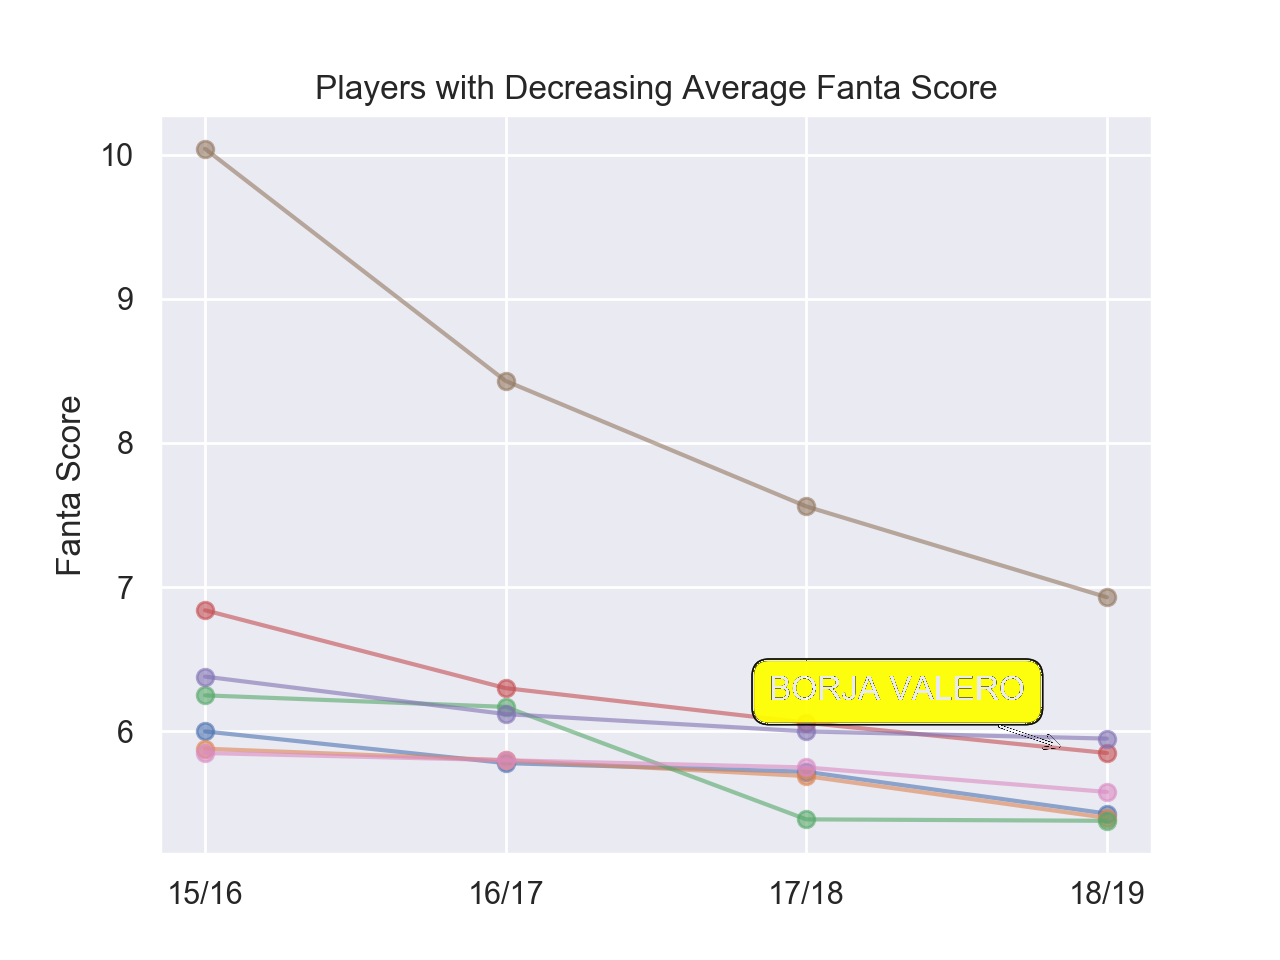

In [13]:
# Plot negative trends

X_TICKS = ['15/16', '16/17', '17/18', '18/19']
# names = ['BACCA',
#          'MANDZUKIC',
#          'BIZARRI',
#          'POSAVEC',
#          'LAMANNA',
#          'CANDREVA',
#          'GILARDINO',
#          'KUCKA',
#          'MBAYE',
#          'TOMOVIC',
#          'CATALDI']
names = []

# Get data
if len(names) > 0:
    data = df_negative_trend[df_negative_trend['nome'].isin(names)]
    data = data.sort_values(['mf1617'], ascending=False)
    names = data['nome'].values
    data = data.values[:, 4:]
else:
    data = df_negative_trend.values[:, 4:]

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):
    if len(names) > 0:
        curr_label = names[i_row]
    else:
        curr_label = df_negative_trend.iloc[i_row, :]['nome']
    ax.plot(row, marker='o', alpha=0.6, label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Decreasing Average Fanta Score')
plt.ylabel('Fanta Score')
if len(names) > 0:
    plt.legend()

### Deltas

In [14]:
# Players' delta - difference between first and last season

COLS_MF = ['mf1516', 'mf1617', 'mf1718', 'mf1819']
COLS_DELTAS = ['nome', 'Delta', 'squadra1819',
               'mf1516', 'mf1617', 'mf1718', 'mf1819']
data_deltas = []
for id_player in df_updated.index:  # for each player...
    player = df_updated.loc[id_player]
    # Calculate delta
    curr_mf = player[COLS_MF].dropna()
    curr_delta = curr_mf[-1] - curr_mf[0]
    # Append to dataset
    row = [player['nome']]
    row.append(curr_delta)
    row.append(player['squadra1819'])
    row.extend(player[COLS_MF])
    data_deltas.append(row)
    
# Create DataFrame
df_deltas = pd.DataFrame(data=data_deltas, columns=COLS_DELTAS)
df_deltas = df_deltas.sort_values(['Delta'])  # sort by delta
df_deltas.head()

,nome,Delta,squadra1819,mf1516,mf1617,mf1718,mf1819
105,HIGUAIN,-3.11,Milan,10.04,8.43,7.56,6.93
73,DYBALA,-1.83,Juventus,8.39,7.90,8.42,6.56
18,VERDI,-1.22,Napoli,7.75,6.94,7.45,6.53
104,HAMSIK,-1.16,Napoli,6.97,7.47,6.58,5.81
12,GIACCHERINI,-1.08,Chievo,6.95,6.44,6.50,5.87


<IPython.core.display.Javascript object>


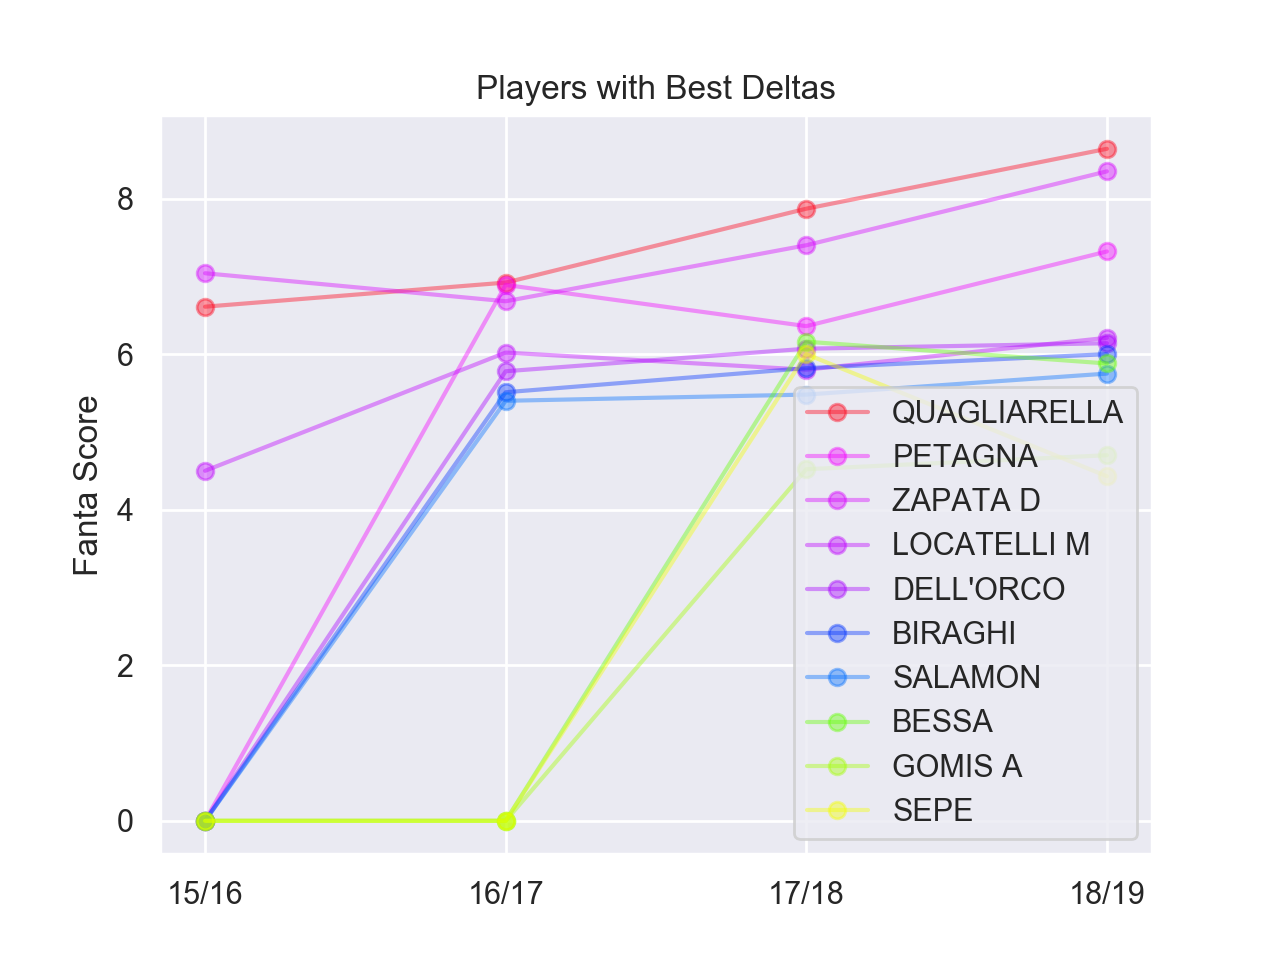

In [15]:
# Players with best positive deltas

X_TICKS = ['15/16', '16/17', '17/18', '18/19']

# Get data
N = 10 + 1
df_deltas_best = df_deltas.iloc[range(len(df_deltas)-1, len(df_deltas)-N, -1), :]
data = df_deltas_best.sort_values(['mf1617'], ascending=False)
labels = data['nome'].values
data = data.values[:, 3:]
delta_max = df_deltas_best['Delta'].max()

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    curr_delta = df_deltas_best.iloc[i_row, :]['Delta']
    curr_label = labels[i_row]
    curr_col = cm.hsv(curr_delta / delta_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Best Deltas')
plt.ylabel('Fanta Score')
plt.legend()

<IPython.core.display.Javascript object>


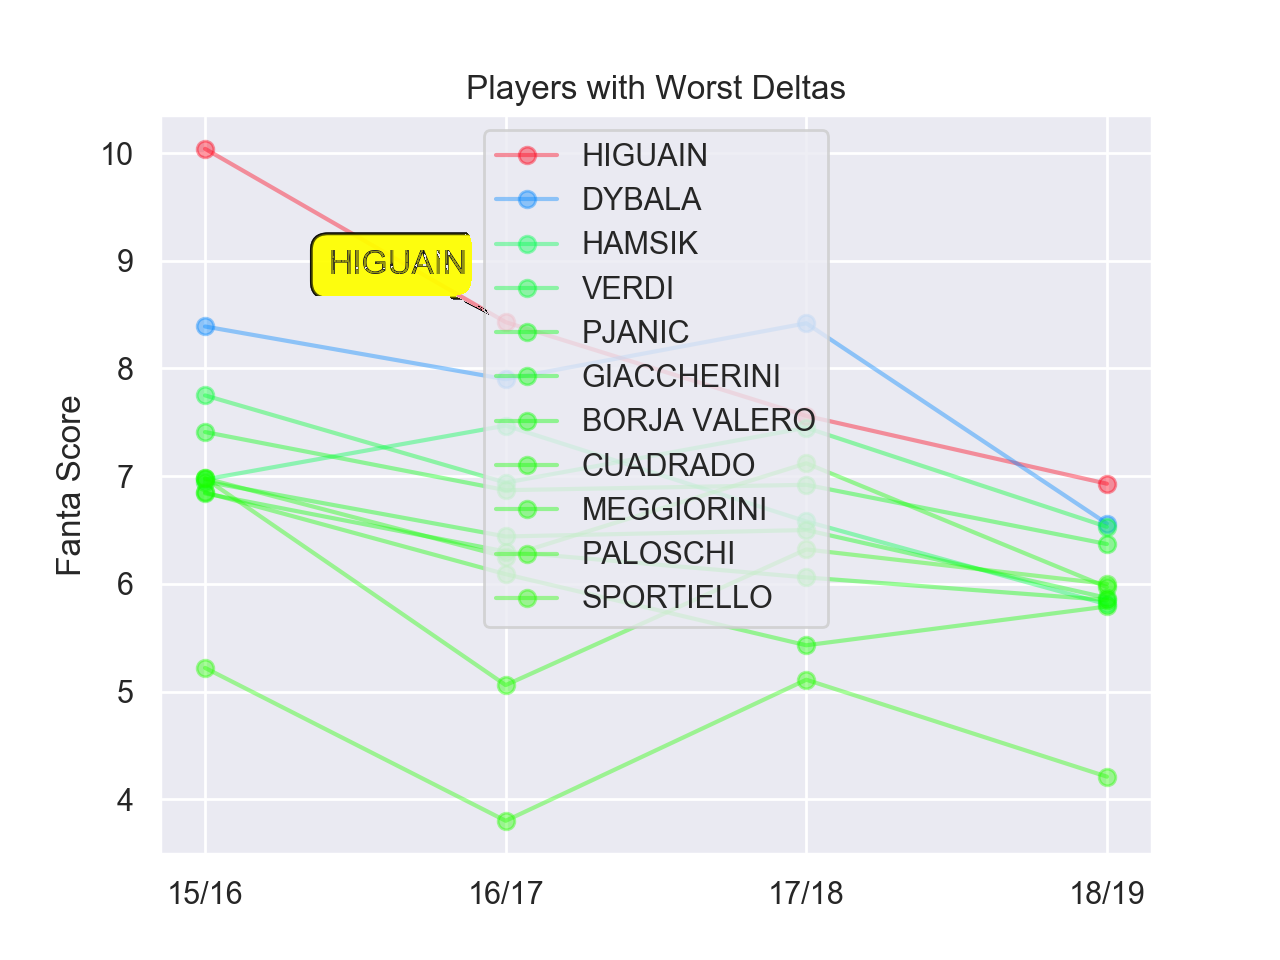

In [16]:
# Players with worst deltas

X_TICKS = ['15/16', '16/17', '17/18', '18/19']

# Get data
N = 10 + 1
df_deltas_worst = df_deltas.iloc[:N, :]
data = df_deltas_worst.sort_values(['mf1617'], ascending=False)
labels = data['nome'].values
data = data.values[:, 3:]
delta_min = df_deltas_worst['Delta'].min()

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    curr_delta = df_deltas_worst.iloc[i_row, :]['Delta']
    curr_label = labels[i_row]
    curr_col = cm.hsv(abs(curr_delta / delta_min))
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Worst Deltas')
plt.ylabel('Fanta Score')
plt.legend()

## Career Mean

In [17]:
# Players' global mean

COLS_MF = ['mf1516', 'mf1617', 'mf1718', 'mf1819', ]
COLS_MEANS = ['nome', 'Mean', 'squadra1819', 'r1819',
               'mf1516', 'mf1617', 'mf1718', 'mf1819']
data_means = []
for id_player in df_updated.index:  # for each player...
    player = df_updated.loc[id_player]
    # Calculate mean
    curr_mf = player[COLS_MF].dropna()
    curr_mean = np.mean(curr_mf)
    # Append to dataset
    row = [player['nome']]
    row.append(curr_mean)
    row.append(player['squadra1819'])
    row.append(player['r1819'])
    row.extend(player[COLS_MF])
    data_means.append(row)
    
# Create DataFrame
df_means = pd.DataFrame(data=data_means, columns=COLS_MEANS)
df_means = df_means.sort_values(['Mean'])  # sort by delta
df_means.head()

,nome,Mean,squadra1819,r1819,mf1516,mf1617,mf1718,mf1819
154,GOMIS A,2.3050,SPAL,P,0.00,0.0,4.52,4.70
44,SEPE,2.6075,Parma,P,0.00,0.0,6.00,4.43
58,BIABIANY,2.9475,Parma,C,6.29,0.0,0.00,5.50
57,BESSA,3.0100,Genoa,C,0.00,0.0,6.16,5.88
2,DJIMSITI,4.1400,Atalanta,D,5.17,0.0,5.53,5.86


<IPython.core.display.Javascript object>


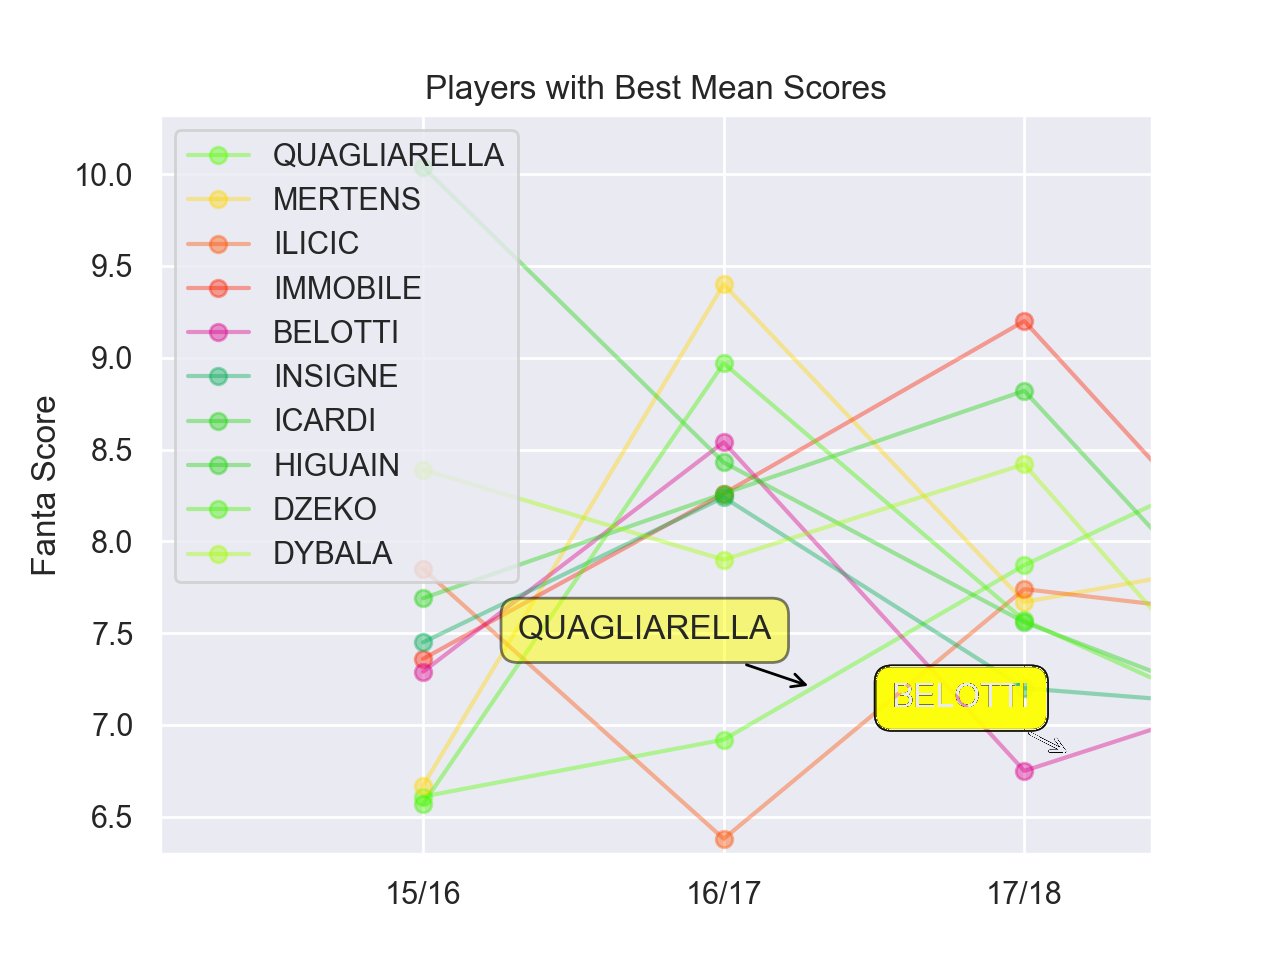

In [18]:
# Players with best mean scores

X_TICKS = ['15/16', '16/17', '17/18', '18/19']

# Get data
N = 10 + 1
df_means_best = df_means.iloc[range(len(df_means)-1, len(df_means)-N, -1), :]
data = df_means_best.sort_values(['mf1819'], ascending=False)
labels = data['nome'].values
data = data.values[:, 4:]
mean_max = df_means_best['Mean'].max()

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    curr_mean = df_means_best.iloc[i_row, :]['Mean']
    curr_label = labels[i_row]
    curr_col = cm.prism(curr_mean / mean_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Best Mean Scores')
plt.ylabel('Fanta Score')
plt.legend()

<IPython.core.display.Javascript object>


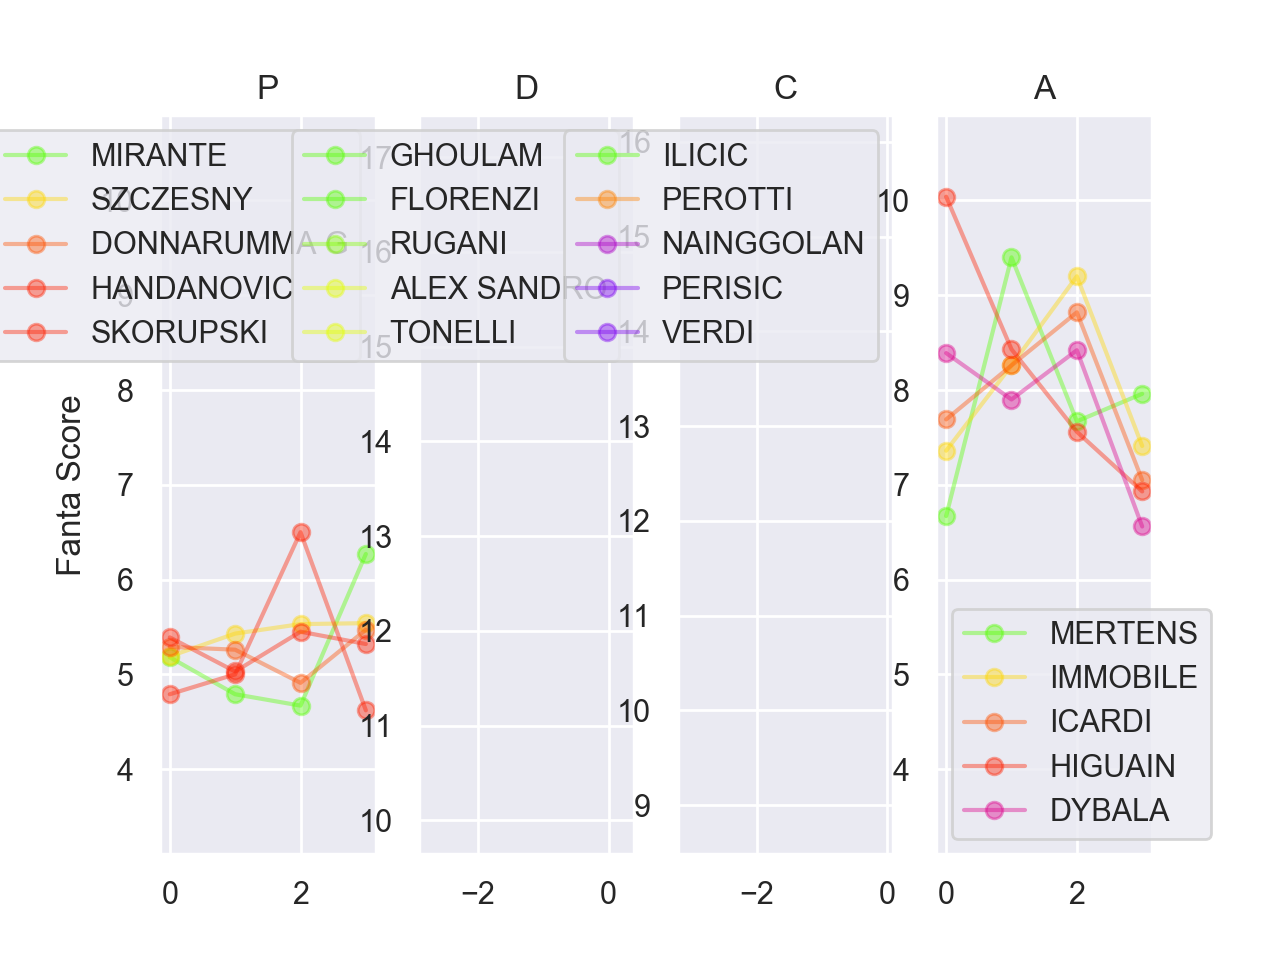

In [19]:
# Best mean scores by role

# Constants
ROLES = ['P', 'D', 'C', 'A']
X_TICKS = ['15/16', '16/17', '17/18', '18/19']
N = 5 + 1

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax = (ax1, ax2, ax3, ax4)

for (i_role, role) in enumerate(ROLES):  # for each role...
    # Get data
    df_means_role = df_means[df_means['r1819'] == role]
    df_means_best_role = df_means_role.iloc[range(len(df_means_role)-1, len(df_means_role)-N, -1), :]
    data = df_means_best_role.sort_values(['mf1819'], ascending=False)
    labels = data['nome'].values
    data = data.values[:, 4:]
    mean_max = df_means_best_role['Mean'].max()

    # Plot data
    for i_row, row in enumerate(data):  # for each player...
        curr_mean = df_means_best_role.iloc[i_row, :]['Mean']
        curr_label = labels[i_row]
        curr_col = cm.prism(curr_mean / mean_max)
        ax[i_role].plot(row, marker='o', 
                        c=curr_col, alpha=0.4,
                        label=curr_label)

    # Initialize interactive tooltip
    mpldatacursor.datacursor(formatter='{label}'.format)

    # Add title and labels
    ax[i_role].set_xticks(range(len(X_TICKS)), X_TICKS)
    ax[i_role].set_title(role)
    if i_role == 0:
        ax[i_role].set_ylabel('Fanta Score')
    ax[i_role].legend()
    ax[i_role].set_ylim([3.1, 10.9])

<IPython.core.display.Javascript object>


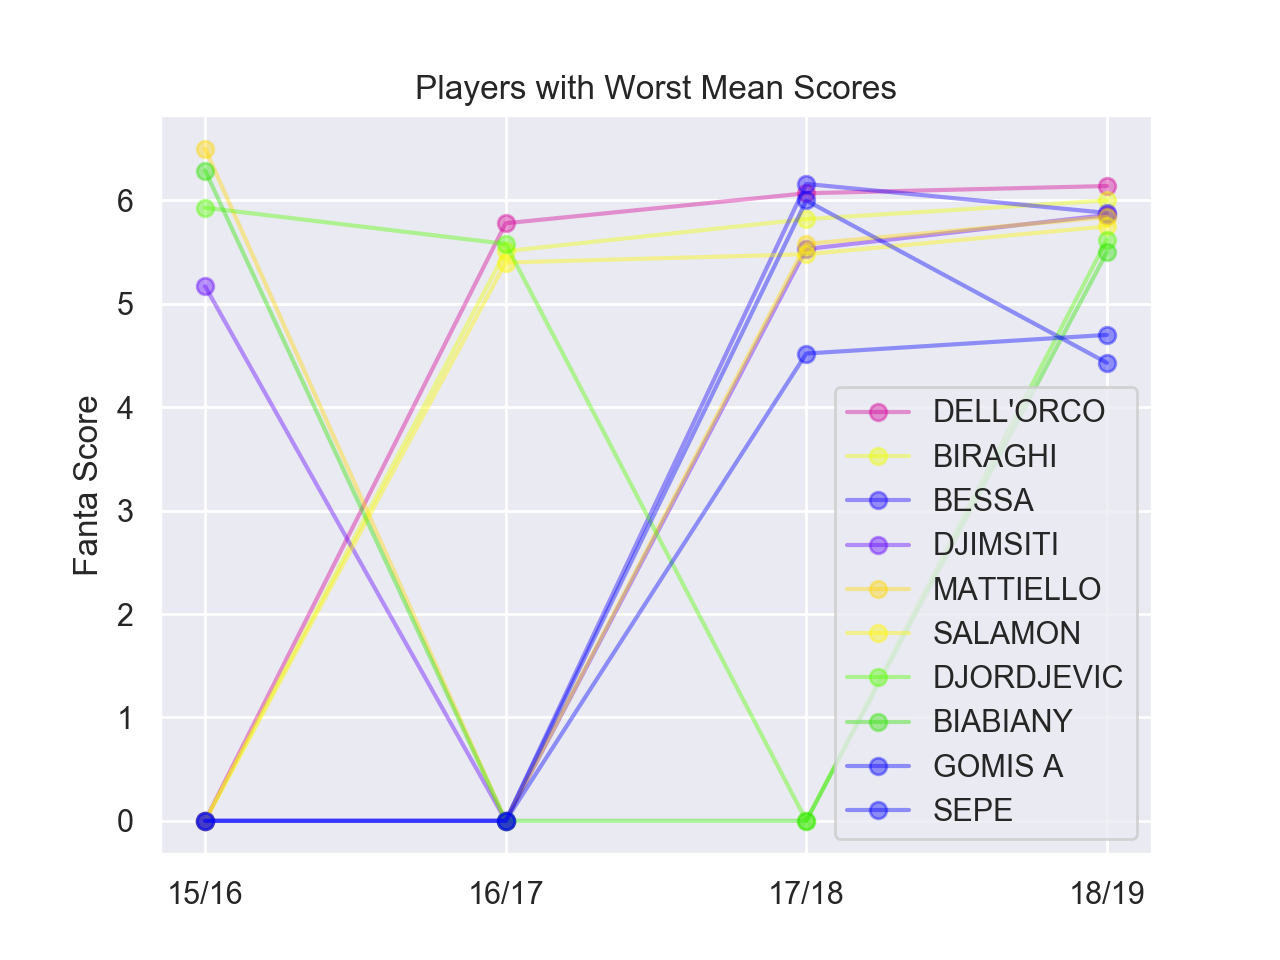

In [20]:
# Players with worst mean scores

X_TICKS  = ['15/16', '16/17', '17/18', '18/19']

# Get data
N = 10
df_means.iloc[:N, :]

# Get data
N = 10
df_means_worst = df_means.iloc[:N, :]
data = df_means_worst.sort_values(['mf1819'], ascending=False)
labels = data['nome'].values
data = data.values[:, 4:]
mean_max = df_means['Mean'].max()

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    curr_mean = df_means_worst.iloc[i_row, :]['Mean']
    curr_label = labels[i_row]
    curr_col = cm.prism(curr_mean / mean_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Worst Mean Scores')
plt.ylabel('Fanta Score')
plt.legend()

## Weighted scores

In [23]:
def _sort_players_by_weighted_score(df, w_d, w_m, w_t, w_y, role=''):
    # Constants
    COLS_MF = ['mf1516', 'mf1617', 'mf1718', 'mf1819']
    COLS_REDUX = ['nome', 'r1819', 'squadra1819', 'mf1516', 'mf1617', 'mf1718', 'mf1819']
    COLS_WEIGHTS = ['nome', 'r1819', 'squadra1819', 'mf1819',
                    'WeightedScore', 'DeltaScore', 'MeanScore', 'TrendScore', 'YearsScore']
    # Filter dataframe
    df_redux = df[COLS_REDUX]
    if len(role) > 0:
        df_redux = df_redux[df_redux['r1819'] == role]
    data_weight_score = []
    for id_player in df_redux.index:  # for each player...
        player = df_redux.loc[id_player]
        name = player['nome']
        # Calculate weighted score
        score = df_redux['mf1819'].values[0]
        score_d = w_d * df_deltas[df_deltas['nome'] == name]['Delta'].values[0]
        score_m = w_m * df_means[df_means['nome'] == name]['Mean'].values[0]
        score_t = 0
        if name in df_positive_trend['nome'].values:
            score_t = w_t
        curr_mf = player[COLS_MF].dropna()
        score_y = w_y * len(curr_mf)
        score_weighted = score + score_d + score_m + score_t + score_y
        # Append to dataset
        row = [name]
        row.append(player['r1819'])
        row.append(player['squadra1819'])
        row.append(player['mf1819'])
        row.append(score_weighted)
        row.extend([score_d, score_m, score_t, score_y])
        data_weight_score.append(row)
    # Create DataFrame and return it
    df_weight_scores = pd.DataFrame(data=data_weight_score, 
                                    columns=COLS_WEIGHTS)
    df_weight_scores = df_weight_scores.sort_values(['WeightedScore'])
    return df_weight_scores

In [25]:
from IPython.display import clear_output
plt.style.use('ggplot')

# Texts
WIDTH_TEXT = 50
text_delta = widgets.FloatText(description="Delta Weight", 
                          value="0.8",
                          width=WIDTH_TEXT)
text_mean = widgets.FloatText(description="Mean Weight", 
                          value="0.7",
                          width=WIDTH_TEXT)
text_trend = widgets.FloatText(description="Trend Weight", 
                          value="1.0",
                          width=WIDTH_TEXT)
text_years = widgets.FloatText(description="Years Weight", 
                          value="0.8",
                          width=WIDTH_TEXT)
display(text_delta)
display(text_mean)
display(text_trend)
display(text_years)

# Dropdown
dropdown_role =  widgets.Dropdown(
    options=['P', 'D', 'C', 'A', 'All'],
    value='A',
    description='Role:',
    disabled=False,
)
display(dropdown_role)

# Button
button_calculate = widgets.Button(description="Calculate")
display(button_calculate)
def on_button_clicked(b):
    # Get values
    w_d = float(text_delta.value)
    w_m = float(text_mean.value)
    w_t = float(text_trend.value)
    w_y = float(text_years.value)
    role = dropdown_role.value
    if len(role) != 1:
        role = ''
    # Players with best weighted scores
    N = 20
    df_weighted_scores = _sort_players_by_weighted_score(df_updated, 
                                                         w_d, w_m, w_t, w_y, role)
    clear_output()
    print(df_weighted_scores.iloc[range(len(df_weighted_scores)-1, 
                                        len(df_weighted_scores)-N, -1), :])
    
# Attach event to button    
button_calculate.on_click(on_button_clicked)



             nome r1819 squadra1819  mf1819  WeightedScore  DeltaScore  \
96        PETAGNA     A        SPAL    7.32       18.37575       5.856   
141     DELL'ORCO     D      Empoli    6.14       17.98025       4.912   
19        BIRAGHI     D  Fiorentina    6.00       17.75275       4.800   
133       SALAMON     D   Frosinone    5.75       17.43025       4.600   
131  QUAGLIARELLA     A   Sampdoria    8.64       16.80100       1.624   
57          BESSA     C       Genoa    5.88       15.73100       4.704   
109       MERTENS     A      Napoli    7.96       15.49950       1.032   
154       GOMIS A     P        SPAL    4.70       15.29350       3.760   
52         PANDEV     A       Genoa    6.60       15.14525       0.880   
161      ZAPATA D     A    Atalanta    8.35       15.12525       1.048   
87         PAROLO     C       Lazio    6.55       14.80675       0.440   
155      IMMOBILE     A       Lazio    7.41       14.60025       0.040   
121   IAGO FALQUE     A      Torino   